Fatma Nur KILINC and Ozgur Erdem ERTUGRUL

Team Name: Bilko

# STEP 3:  Quanvolutional Neural Networks

In this demo, we create a Quanvolutional Neural Network, a type of quantum machine learning model first introduced by [Henderson et al.](https://arxiv.org/abs/1904.04767) in 2019.

Convolutional Neural Networks (CNNs) are commonly used in classical machine learning for image processing by applying local convolutions to small regions of an image with the same kernel. The results are combined into output pixels, forming a new image-like object for further processing.

Quantum variational circuits can extend convolution to quantum computing. In this approach, small regions of an image, like 2×2 squares, are embedded into quantum circuits using parameterized rotations. A unitary operation is performed, and the system is measured to obtain classical expectation values, which are mapped to channels of an output pixel. Repeating this across different regions processes the entire image into a multi-channel output. Quantum circuits can create complex kernels that are difficult to compute classically. The tutorial uses a fixed, non-trainable "quanvolution" kernel, but these kernels can also be trained using PennyLane's gradient evaluation capabilities.

In [12]:
pip install pennylane

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Set the hyperparameters:

In [2]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "../"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

Import the MNIST dataset from Keras.

In [3]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

We set up a PennyLane *default.qubit* device to simulate a system with 4 qubits. QNode includes the following components:

* An embedding layer with local \( R_y \) rotations, where angles are scaled by a factor of \(π\).
* A random circuit with a specified number of layers (*n_layers*).
* A final measurement in the computational basis to estimate 4 expectation values.

In [4]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

The convolution procedure:

* The image is divided into 2×2 pixel squares.
* Each square is processed by the quantum circuit.
* The 4 expectation values obtained are mapped to 4 different channels of a single output pixel.


In [5]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

Since the quantum convolution layer won't be trained, it's more efficient to use it as a pre-processing step for the entire dataset. Pre-processed images are saved to `SAVE_PATH` and can be loaded by setting `PREPROCESS = False`. If `PREPROCESS` is True, the quantum convolution is applied each time the code runs.

In [6]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


 Below each input image, the 4 output channels from the quantum convolution are displayed in grayscale. The 4 grayscale output channels from the quantum convolution show reduced resolution and some local distortion, but the overall image shape remains preserved.

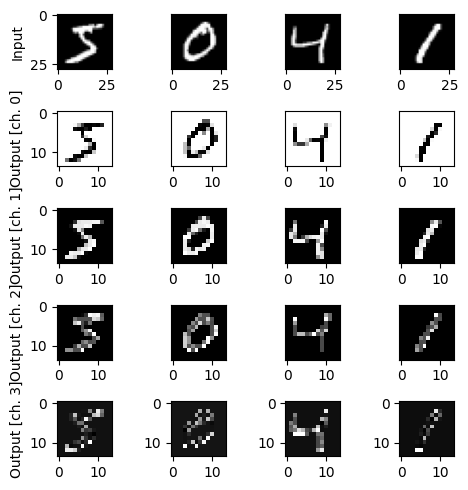

In [7]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(5, 5))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

After applying the quantum convolution layer, the features are input into a simple classical neural network for classifying the 10 MNIST digits. The model consists of a fully connected layer with 10 output nodes and a softmax activation function, and is compiled with stochastic gradient descent and a cross-entropy loss function.

In [8]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

We first initialize the model, then train and validate it using the pre-processed dataset from the quantum convolution.

In [9]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 91ms/step - accuracy: 0.1200 - loss: 2.7125 - val_accuracy: 0.1333 - val_loss: 2.4208
Epoch 2/30
13/13 - 0s - 7ms/step - accuracy: 0.3400 - loss: 1.9691 - val_accuracy: 0.1667 - val_loss: 2.2893
Epoch 3/30
13/13 - 0s - 6ms/step - accuracy: 0.5600 - loss: 1.6552 - val_accuracy: 0.3000 - val_loss: 2.0411
Epoch 4/30
13/13 - 0s - 6ms/step - accuracy: 0.7200 - loss: 1.3413 - val_accuracy: 0.4000 - val_loss: 1.8975
Epoch 5/30
13/13 - 0s - 6ms/step - accuracy: 0.8200 - loss: 1.1096 - val_accuracy: 0.4333 - val_loss: 1.7906
Epoch 6/30
13/13 - 0s - 6ms/step - accuracy: 0.9400 - loss: 0.9237 - val_accuracy: 0.4667 - val_loss: 1.6929
Epoch 7/30
13/13 - 0s - 6ms/step - accuracy: 0.9600 - loss: 0.7785 - val_accuracy: 0.5333 - val_loss: 1.6156
Epoch 8/30
13/13 - 0s - 11ms/step - accuracy: 0.9800 - loss: 0.6606 - val_accuracy: 0.5333 - val_loss: 1.5526
Epoch 9/30
13/13 - 0s - 10ms/step - accuracy: 0.9800 - loss: 0.5644 - val_accuracy: 0.5667 - val_loss: 1.4985
Epoch 10/30
13/1

To compare results, we also initialize a "classical" model that is trained and validated directly with the raw MNIST images, without quantum pre-processing.

In [10]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 64ms/step - accuracy: 0.1200 - loss: 2.4187 - val_accuracy: 0.1000 - val_loss: 2.2750
Epoch 2/30
13/13 - 0s - 7ms/step - accuracy: 0.3600 - loss: 1.9800 - val_accuracy: 0.2000 - val_loss: 2.1297
Epoch 3/30
13/13 - 0s - 10ms/step - accuracy: 0.5600 - loss: 1.6814 - val_accuracy: 0.4000 - val_loss: 1.9992
Epoch 4/30
13/13 - 0s - 6ms/step - accuracy: 0.7200 - loss: 1.4427 - val_accuracy: 0.4333 - val_loss: 1.8777
Epoch 5/30
13/13 - 0s - 11ms/step - accuracy: 0.8600 - loss: 1.2451 - val_accuracy: 0.4667 - val_loss: 1.7696
Epoch 6/30
13/13 - 0s - 12ms/step - accuracy: 0.8800 - loss: 1.0807 - val_accuracy: 0.5333 - val_loss: 1.6776
Epoch 7/30
13/13 - 0s - 9ms/step - accuracy: 0.9400 - loss: 0.9438 - val_accuracy: 0.5667 - val_loss: 1.6004
Epoch 8/30
13/13 - 0s - 13ms/step - accuracy: 0.9600 - loss: 0.8294 - val_accuracy: 0.6000 - val_loss: 1.5353
Epoch 9/30
13/13 - 0s - 12ms/step - accuracy: 0.9800 - loss: 0.7331 - val_accuracy: 0.6000 - val_loss: 1.4799
Epoch 10/30
1

Plot of the test accuracy and the test loss of classical and quantum-classical models with respect to the number of training epochs.

<ipython-input-11-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


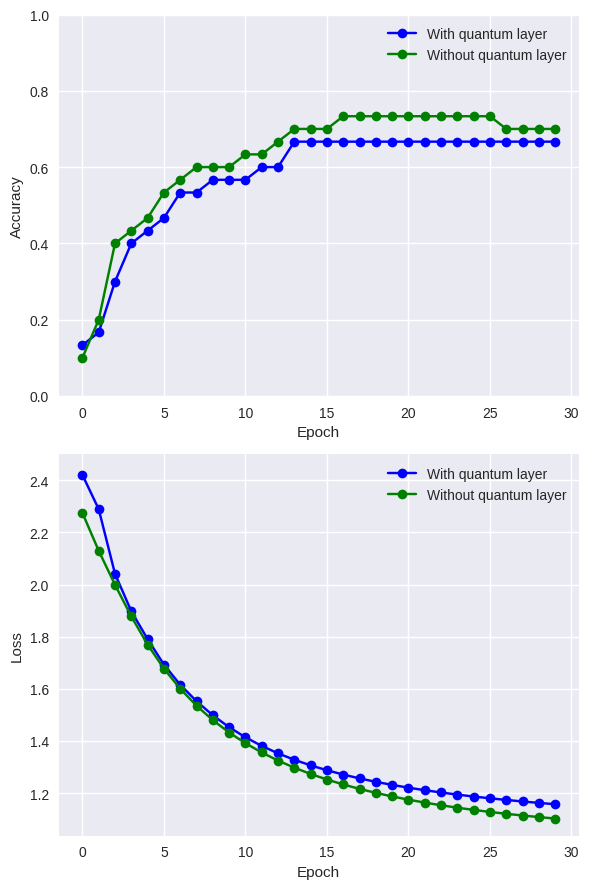

In [11]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()